In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [4]:
# Load dataset
df = pd.read_csv("data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
# Drop useless columns
df = df.drop(columns=["id", "Unnamed: 32"])

# Encode diagnosis: M -> 1 (malignant), B -> 0 (benign)
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})


In [6]:
# Separate features and target
X = df.drop(columns=["diagnosis"]).values
y = df["diagnosis"].values

In [7]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X = standardize(X)


In [8]:
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split = int(len(X) * (1 - test_size))
    train_idx = indices[:split]
    test_idx = indices[split:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [9]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def minkowski(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

def cosine(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hamming(a, b):
    return np.sum(a != b)


In [10]:
distance_metrics = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}


In [11]:
class KNN:
    def __init__(self, k, distance_func):
        self.k = k
        self.distance_func = distance_func

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict_one(self, x):
        distances = []
        for i in range(len(self.X)):
            d = self.distance_func(x, self.X[i])
            distances.append((d, self.y[i]))

        distances.sort(key=lambda x: x[0])
        neighbors = distances[:self.k]

        labels = [label for _, label in neighbors]
        return Counter(labels).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


In [12]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, fp, fn, tn

def precision(tp, fp):
    return tp / (tp + fp + 1e-9)

def recall(tp, fn):
    return tp / (tp + fn + 1e-9)


In [13]:
K_values = [3, 4, 9, 20, 47]
results = {}

for name, dist_func in distance_metrics.items():
    accuracies = []

    for k in K_values:
        model = KNN(k, dist_func)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy(y_test, preds)
        accuracies.append(acc)

    results[name] = accuracies


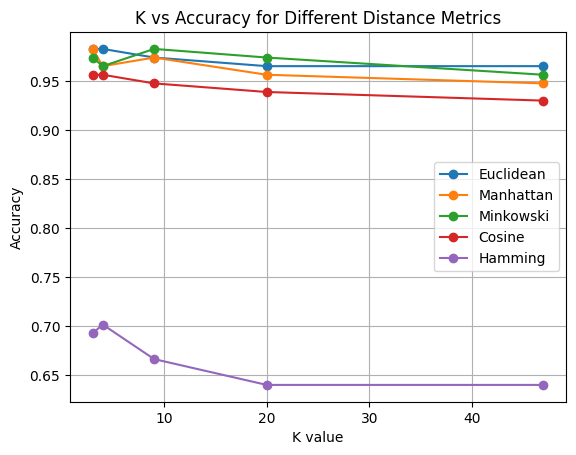

In [14]:
for name, accs in results.items():
    plt.plot(K_values, accs, marker='o', label=name)

plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("K vs Accuracy for Different Distance Metrics")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
best_k = 9
best_distance = euclidean

best_model = KNN(best_k, best_distance)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

tp, fp, fn, tn = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print("TP:", tp, "FP:", fp)
print("FN:", fn, "TN:", tn)

print("Accuracy:", accuracy(y_test, y_pred))
print("Precision:", precision(tp, fp))
print("Recall:", recall(tp, fn))


Confusion Matrix:
TP: 39 FP: 1
FN: 2 TN: 72
Accuracy: 0.9736842105263158
Precision: 0.974999999975625
Recall: 0.9512195121719216
